In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import seaborn as sns 
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=ConvergenceWarning)

/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
ENSEMBLE_PATH = os.path.join(DATA_PATH, 'ensemble/malhotra')

In [3]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
test_df.shape (4209, 377)


In [4]:
filter_outliers = True
xgb_use_augment_features = True
add_magic_feature = True
log_transform_y = False
log_transform_y_n = 5
keep_ID = False

if log_transform_y:
    print('Transforming y -> ln(y+{})'.format(log_transform_y_n))
    train_df.loc[:, 'y'] = np.log(train_df.y + log_transform_y_n)

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

# Preprocess data
print('Dropping constant value columns')
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
        
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    lbl = preprocessing.LabelEncoder()
    train_values = set(train_df[f].values)
    test_values = set(test_df[f].values)
    all_values = list(train_values | test_values)
    lbl.fit(all_values) 
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))

if xgb_use_augment_features:
    n_comp = 10
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
    pca2_results_test = pca.transform(test_df)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
    ica2_results_test = ica.transform(test_df)

    # GRP
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
    grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
    grp_results_test = grp.transform(test_df)

    # SRP
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
    srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
    srp_results_test = srp.transform(test_df)
    
    # Append decomposition components to datasets
    for i in range(0, n_comp):
        train_df['pca_' + str(i)] = pca2_results_train[:, i]
        test_df['pca_' + str(i)] = pca2_results_test[:, i]

        train_df['ica_' + str(i)] = ica2_results_train[:, i]
        test_df['ica_' + str(i)] = ica2_results_test[:, i]
        
        train_df['grp_' + str(i)] = grp_results_train[:, i]
        test_df['grp_' + str(i)] = grp_results_test[:, i]
        
        train_df['srp_' + str(i)] = srp_results_train[:, i]
        test_df['srp_' + str(i)] = srp_results_test[:, i]
        
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

Filtering outliers
Dropping constant value columns
train_df.shape (4208, 406)
test_df.shape (4209, 405)


In [93]:
if keep_ID:
    print('Keeping ID in training columns')
    X = train_df.drop(['y'], axis=1)
    test_X = test_df
else:
    X = train_df.drop(["y"], axis=1).set_index(['ID'], drop=True)
    test_X = test_df.set_index(['ID'], drop=True)

Y = train_df['y'].values

print('X.shape', X.shape)
print('Y.shape', Y.shape)

if add_magic_feature:    
    temp_X = X.copy()
    temp_X['y'] = Y
    median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
    test_X_median_df = pd.merge(test_X, median_df, on='X0', how='left')
    test_X_median_df.loc[test_X_median_df.median_y.isnull(), 'median_y'] = Y.mean()
    test_X = test_X_median_df
    test_X = test_X.set_index(test_df.ID.values)
    test_X.index.name = 'ID'
    print('test_X.shape', test_X.shape)

X.shape (4208, 404)
Y.shape (4208,)
test_X.shape (4209, 405)


In [74]:
NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

dataset_blend_train = np.zeros((X.shape[0]))
dataset_blend_test = np.zeros((test_X.shape[0]))
dataset_blend_test_j = np.zeros((test_X.shape[0], NUM_FOLDS))

for fold, (train_idxs, val_idxs) in enumerate(kf.split(X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = X.iloc[train_idxs], X.iloc[val_idxs]
    trn_Y, val_Y = Y[train_idxs], Y[val_idxs]
    
    mean_Y = trn_Y.mean()
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df

    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 5,
                        objective="reg:linear",
                        n_estimators=1500,
                        learning_rate=0.0045,
                        nthread=12,
                        subsample=0.93,
                        base_score=mean_Y,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    
    trn_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    test_Y_pred = model.predict(test_X)
    dataset_blend_train[val_idxs] = val_Y_pred
    dataset_blend_test_j[:, fold] = model.predict(test_X)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score,
                 train_var, val_var,
                 train_mae, val_mae))
dataset_blend_test = dataset_blend_test_j.mean(1)

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2',
                                      'train_var', 'validation_var',
                                      'train_mae', 'validation_mae'])

val_r2_mean = "{:0.5f}".format(perf_df['validation_r2'].mean())[2:]
ts = str(int(time.time()))

train_blend_df = pd.DataFrame(data=dataset_blend_train, index=X.index, columns=['y'])
test_blend_df = pd.DataFrame(data=dataset_blend_test, index=test_X.index, columns=['y'])

train_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_train.csv'.format(ts, 0, val_r2_mean)), index=True)
test_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_test.csv'.format(ts, 0, val_r2_mean)), index=True)

print('avg train r2', perf_df['train_r2'].mean(),
      'avg validation r2', perf_df['validation_r2'].mean(), 
      'avg train var', perf_df['train_var'].mean(),
      'avg validation var', perf_df['validation_var'].mean(),
      'avg train mae', perf_df['train_mae'].mean(),
      'avg validation mae', perf_df['validation_mae'].mean())
perf_df

Fold 0 Training model-1498527973
Fold 1 Training model-1498527976
Fold 2 Training model-1498527978
Fold 3 Training model-1498527981
Fold 4 Training model-1498527985
avg train r2 0.69585146229 avg validation r2 0.578672406607 avg train var 85.6326309204 avg validation var 84.2028625488 avg train mae 4.6940091493 avg validation mae 5.34648297159


,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1498527973,0.697896,0.569954,86.209091,86.588310,4.675596,5.409609
1,1,model-1498527976,0.684908,0.539071,82.143288,78.153618,4.744595,5.498620
2,2,model-1498527978,0.682988,0.612132,83.106895,84.166046,4.800827,5.219504
3,3,model-1498527981,0.701875,0.601637,89.145493,83.738861,4.698134,5.230810
4,4,model-1498527985,0.711590,0.570567,87.558388,88.367477,4.550893,5.373872


In [41]:
# Avg xgb models predictions
# VALIDATION_THRESHOLD = 0.4
# NUM_MODELS = perf_df[perf_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
# train_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
# holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
# test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

# count = 0
# for row in perf_df.itertuples():
#     fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
#     if validation_r2 < VALIDATION_THRESHOLD:
#         continue
#     model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.xgb'), 'rb'))
#     test_Y_pred[:, count] = model.predict(test_X)
#     holdout_Y_pred[:, count] = model.predict(holdout_X)
#     train_Y_pred[:, count] = model.predict(X)
#     count += 1

# holdout_Y_avg = np.mean(holdout_Y_pred, axis=1)
# train_Y_avg = np.mean(train_Y_pred, axis=1)
# test_Y_avg = np.mean(test_Y_pred, axis=1)
# test_Y_avg.shape

NameError: name 'holdout_X' is not defined

In [86]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

dataset_blend_train = np.zeros((X.shape[0]))
dataset_blend_test = np.zeros((test_X.shape[0]))
dataset_blend_test_j = np.zeros((test_X.shape[0], NUM_FOLDS))

for fold, (train_idxs, val_idxs) in enumerate(kf.split(X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = X.iloc[train_idxs], X.iloc[val_idxs]
    trn_Y, val_Y = Y[train_idxs], Y[val_idxs]
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
    
    stacked_pipeline = make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                              n_estimators=500, max_depth=3,
                                                              max_features=0.55, min_samples_leaf=18,
                                                              min_samples_split=14, subsample=0.7)),
        LassoLarsCV())
    stacked_pipeline.fit(trn_X, trn_Y)
    pickle.dump(stacked_pipeline, open(os.path.join(MODELS_PATH, model_id + ".stacked"), "wb"))
   
    trn_Y_pred = stacked_pipeline.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = stacked_pipeline.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    test_Y_pred = model.predict(test_X)
    dataset_blend_train[val_idxs] = val_Y_pred
    dataset_blend_test_j[:, fold] = model.predict(test_X)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score,
                 train_var, val_var, 
                 train_mae, val_mae))

dataset_blend_test = dataset_blend_test_j.mean(1)

perf_stacked_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2',
                                      'train_var', 'validation_var', 
                                      'train_mae', 'validation_mae'])

val_r2_mean = val_r2_mean = "{:0.5f}".format(perf_stacked_df['validation_r2'].mean())[2:]
ts = str(int(time.time()))

train_blend_df = pd.DataFrame(data=dataset_blend_train, index=X.index, columns=['y'])
test_blend_df = pd.DataFrame(data=dataset_blend_test, index=test_X.index, columns=['y'])

train_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_stacked5fold_{}_{}_{}_train.csv'.format(ts, 0, val_r2_mean)), index=True)
test_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_stacked5fold_{}_{}_{}_test.csv'.format(ts, 0, val_r2_mean)), index=True)

print('avg train r2', perf_stacked_df['train_r2'].mean(),
      'avg validation r2', perf_stacked_df['validation_r2'].mean(), 
      'avg train var', perf_stacked_df['train_var'].mean(),
      'avg validation var', perf_stacked_df['validation_var'].mean(),
      'avg train mae', perf_stacked_df['train_mae'].mean(),
      'avg validation mae', perf_stacked_df['validation_mae'].mean())
perf_stacked_df

Fold 0 Training model-1498534428


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 1 Training model-1498534440


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))


Fold 2 Training model-1498534451


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 3 Training model-1498534463


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 4 Training model-1498534475


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


avg train r2 0.610828705093 avg validation r2 0.593431939622 avg train var 85.1534595384 avg validation var 84.9488373355 avg train mae 5.15805442387 avg validation mae 5.26452318577


,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1498534428,0.616554,0.570844,86.368970,88.067598,5.119727,5.396531
1,1,model-1498534440,0.615157,0.554086,83.093900,79.866673,5.125830,5.437177
2,2,model-1498534451,0.603708,0.641887,86.263802,91.300010,5.198318,5.059151
3,3,model-1498534463,0.606895,0.617144,86.321135,81.418986,5.231673,5.100319
4,4,model-1498534475,0.611829,0.583200,83.719490,84.090920,5.114725,5.329437


In [87]:
perf_df

,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1498527973,0.697896,0.569954,86.209091,86.588310,4.675596,5.409609
1,1,model-1498527976,0.684908,0.539071,82.143288,78.153618,4.744595,5.498620
2,2,model-1498527978,0.682988,0.612132,83.106895,84.166046,4.800827,5.219504
3,3,model-1498527981,0.701875,0.601637,89.145493,83.738861,4.698134,5.230810
4,4,model-1498527985,0.711590,0.570567,87.558388,88.367477,4.550893,5.373872


In [88]:
perf_stacked_df

,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1498534428,0.616554,0.570844,86.368970,88.067598,5.119727,5.396531
1,1,model-1498534440,0.615157,0.554086,83.093900,79.866673,5.125830,5.437177
2,2,model-1498534451,0.603708,0.641887,86.263802,91.300010,5.198318,5.059151
3,3,model-1498534463,0.606895,0.617144,86.321135,81.418986,5.231673,5.100319
4,4,model-1498534475,0.611829,0.583200,83.719490,84.090920,5.114725,5.329437


In [44]:
# Avg stacked models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_stacked_df[perf_stacked_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
train_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_stacked_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < 0.4:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.stacked'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X)
    holdout_Y_pred[:, count] = model.predict(holdout_X)
    train_Y_pred[:, count] = model.predict(X)
    count += 1

holdout_Y_avg_stacked = np.mean(holdout_Y_pred, axis=1)
train_Y_avg_stacked = np.mean(train_Y_pred, axis=1)
test_Y_avg_stacked = np.mean(test_Y_pred, axis=1)
test_Y_avg_stacked.shape

(4209,)

In [46]:
weight_limits_xgb = [0.0, 1.0]
weights = np.arange(weight_limits_xgb[0], weight_limits_xgb[1], 0.05)
holdout_perf = np.ndarray(shape=(len(weights), 3), dtype=np.float32)

# Weighted average of predictions
for idx, weight_xgb in enumerate(weights):
    weight_stacked = 1.0 - weight_xgb
    holdout_Y_ensembled = holdout_Y_avg * weight_xgb + holdout_Y_avg_stacked * weight_stacked
    holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
    holdout_perf[idx, :] = [weight_xgb, weight_stacked, holdout_r2_ensemble]
    #print('weight_xgb', weight_xgb, 'weight_stacked', weight_stacked, 'holdout_r2_ensemble', holdout_r2_ensemble)

holdout_max_index = np.argmax(holdout_perf[:, 2])

train_Y_ensembled = train_Y_avg * holdout_perf[holdout_max_index, 0] + train_Y_avg_stacked * holdout_perf[holdout_max_index, 1]
holdout_Y_ensembled = holdout_Y_avg * holdout_perf[holdout_max_index, 0] + holdout_Y_avg_stacked * holdout_perf[holdout_max_index, 1]
holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
test_Y_ensemble_1 = test_Y_avg * holdout_perf[holdout_max_index, 0] + test_Y_avg_stacked * holdout_perf[holdout_max_index, 1]
print('\nweight_xgb', holdout_perf[holdout_max_index, 0], 'weight_stacked', holdout_perf[holdout_max_index, 1], 
     'holdout_r2_ensemble', holdout_r2_ensemble)

NameError: name 'train_Y_avg' is not defined

In [91]:
high_idxs = np.where(holdout_Y_ensembled > 110.0)
high_idxs

(array([  3,   5,   6,   7,   8,  12,  15,  18,  21,  22,  26,  41,  42,
         45,  47,  53,  54,  56,  59,  61,  64,  68,  70,  73,  74,  78,
         83,  87,  88,  91,  94,  96,  97, 106, 107, 108, 110, 113, 114,
        117, 119, 120, 123, 134, 142, 144, 146, 150, 157, 159, 160, 163,
        166, 171, 177, 190, 191, 193, 194, 208, 212, 213, 218, 231, 232,
        236, 247, 250, 251, 253, 255, 259, 265, 268, 274, 276, 279, 280,
        282, 292, 299, 300, 308, 310, 312, 318, 322, 324, 329, 330, 337,
        342, 344, 345, 356, 359, 365, 371, 373, 380, 381, 383, 386, 388,
        390, 394, 396, 399, 404, 405, 411, 418, 422, 423, 427, 428, 435,
        436, 438, 441, 446, 447, 449, 460, 462, 463, 464, 466, 468, 474,
        476, 485, 486, 487, 488, 489, 490, 493, 494, 496, 502, 503, 505,
        508, 511, 514, 517, 528, 529, 532, 533, 534, 542, 543, 544, 567,
        568, 569, 570, 574, 575, 576, 582, 586, 587, 589, 593, 596, 599,
        601, 602, 603, 609, 614, 622, 623, 624, 625

In [92]:
holdout_Y_ensembled[high_idxs] += 5
holdout_Y_ensembled

array([  95.40280151,   94.74695587,   94.7228241 ,  116.92957306,
         94.17668915,  118.98272705,  116.760849  ,  116.96318054,
        120.49378204,   92.87089539,   94.98645782,  103.72973633,
        119.01902771,  103.35417175,  105.31628418,  116.74468231,
         94.51301575,  103.95970917,  116.90180206,   79.10095215,
         94.31027985,  117.02548218,  117.11342621,   94.75508118,
         93.95848083,  103.49342346,  119.81903076,   94.23448944,
         93.94496155,   94.20629883,   94.20709229,  103.68806458,
         93.95300293,   93.79988861,   94.22543335,   93.99928284,
         94.42774963,   93.81678772,   94.93397522,  104.0883255 ,
         95.04811859,  116.98084259,  116.71513367,   94.15391541,
         94.29434204,  116.95269012,   79.2207489 ,  117.05097961,
         94.30940247,   94.24176788,  103.79586029,   94.88846588,
         94.2628479 ,  116.72222137,  120.44460297,  103.62063599,
        116.93894958,   93.69264221,   93.85028076,  116.48100

In [93]:
holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
#print(holdout_r2_ensemble)
print('\nweight_xgb', holdout_perf[holdout_max_index, 0], 'weight_stacked', holdout_perf[holdout_max_index, 1], 
     'holdout_r2_ensemble', holdout_r2_ensemble)


weight_xgb 0.05 weight_stacked 0.95 holdout_r2_ensemble 0.569842865751


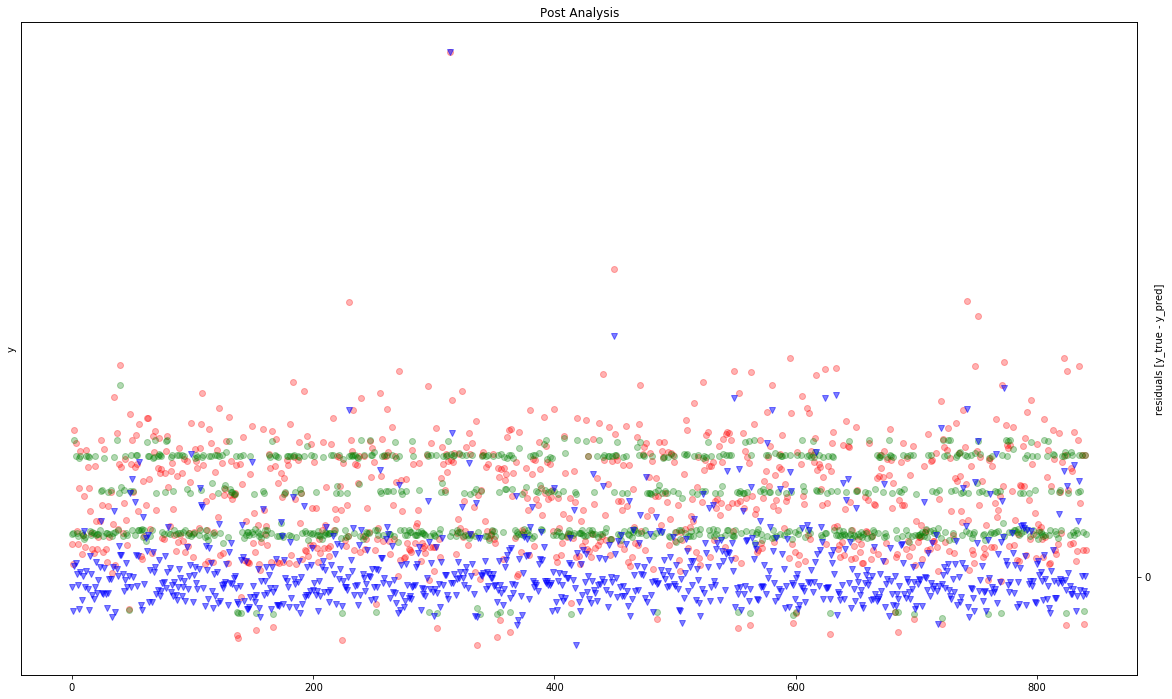

In [66]:
#post_analysis = val_x.copy()
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = holdout_Y_ensembled
post_analysis['y_true'] = holdout_Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
#ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

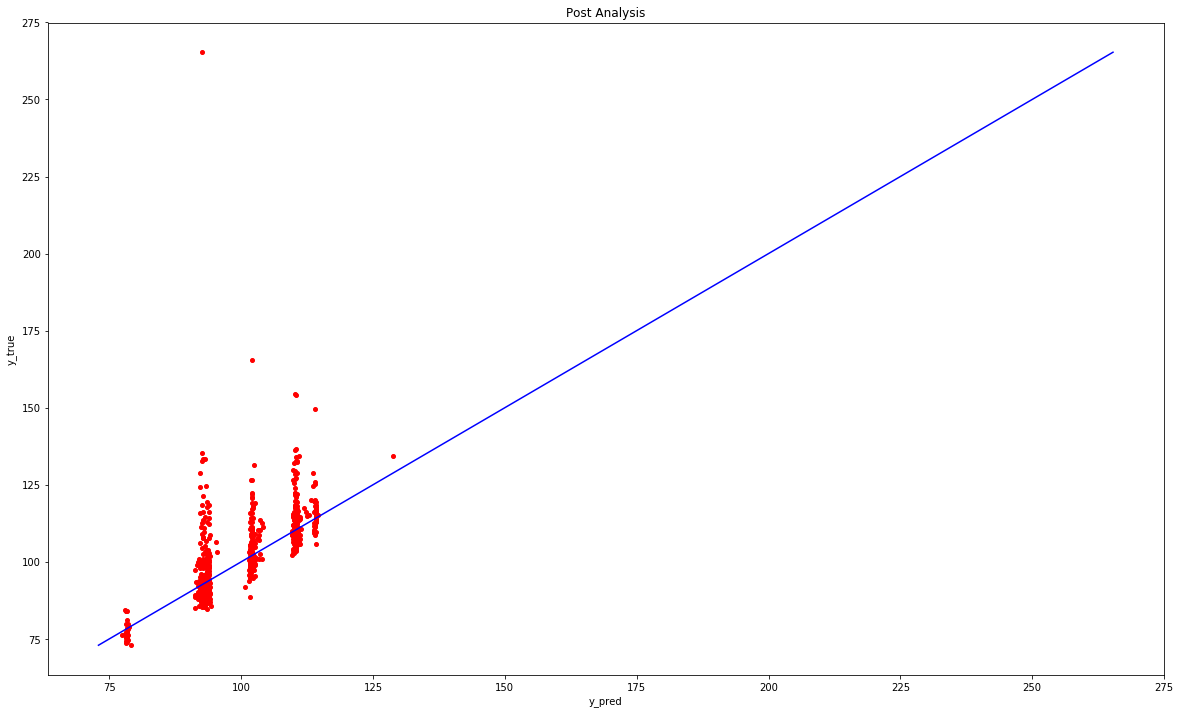

In [67]:
post_analysis = pd.DataFrame()
if log_transform_y:
    post_analysis['y_pred'] = np.exp(holdout_Y_ensembled) - log_transform_y_n
    post_analysis['y_true'] = np.exp(holdout_Y) - log_transform_y_n
else:
    post_analysis['y_pred'] = holdout_Y_ensembled
    post_analysis['y_true'] = holdout_Y
# post_analysis['y_pred'] = holdout_Y_ensembled
# post_analysis['y_true'] = holdout_Y

lims = [
    np.min([post_analysis.y_pred.values, post_analysis.y_true.values]),  # min of both axes
    np.max([post_analysis.y_pred.values, post_analysis.y_true.values]),  # max of both axes
]

# now plot both limits against eachother
fig, ax1 = plt.subplots(figsize=(20,12))
plt.title('Post Analysis')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.plot(post_analysis.y_pred.values, post_analysis.y_true.values,'ro', markersize=4.0)
plt.plot(lims, lims, 'b-')

plt.show()

In [90]:
# high_idxs = np.where(test_Y_ensemble_1 > 110.0)
# test_Y_ensemble_1[high_idxs] += 1
# test_Y_ensemble_1

array([  82.21172333,   99.89054871,   82.24549103, ...,   93.38601685,
        112.56864166,   93.41998291], dtype=float32)

In [58]:
# Create submission file
submission_df = test_df[['ID']]
if log_transform_y:
    result = np.exp(test_Y_ensemble_1) - log_transform_y_n
else:
    result = test_Y_ensemble_1
submission_df['y'] = result.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1498414265.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


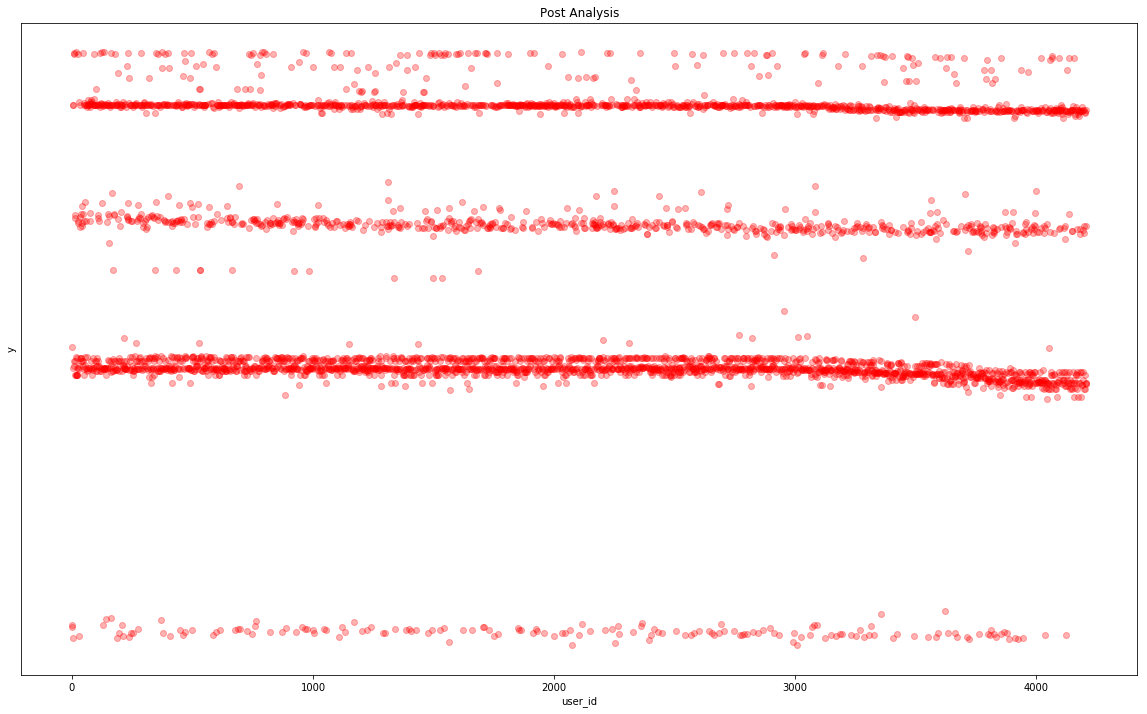

In [59]:
#post_analysis = val_x.copy()
post_analysis = pd.DataFrame()
post_analysis['y_test'] = result
#post_analysis['y_true'] = holdout_Y
#post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
#ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
#ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_test'],'ro', alpha=0.30)
#ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
#ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
#ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
#ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()